# Endorsements and reactions - Retweets and Quoted tweets 

Plausible assumptions from existing research:
1. **Retweets** are **endorsements** 
2. **Quoted tweets** are **reactions** - can be positive, negative or neutral 

### [Table of Contents](#cell2)

* 1\. [Distribution of retweets, replies and quoted tweets](#cell1)
* 2\. [Foreign influence: Inferring the influential countries](#cell2)
* 3\. [Bursty tweets: Inferring tweets with high intensity of extreme sentiments](#cell3)
    * 3.1. [Inferring viral quoted tweets](#cell31)
    * 3.2. [Sentiment analysis of the viral quoted tweets](#cell32)
    * 3.3. [Inferring viral quoted tweets with extreme intensity of sentiments](#cell33)
* 4\. [Viral local retweets: Local news feed](#cell4)
    * 4.1. [Viral local retweets with negative sentiment](#cell41)
    * 4.2. [Viral local retweets with positive sentiment](#cell42)
<!--     * 4.3. [Viral local retweets with all sentiments (general)](#cell43) -->
* 5\. [Viral global retweets: Global news feed](#cell5)
    * 5.1. [Viral global retweets with negative sentiment](#cell51)
    * 5.2. [Viral global retweets with positive sentiment](#cell52)
<!--     * 5.3. [Viral global retweets with all sentiments (general)](#cell53) -->

In [1]:
import re
import os
import time
import glob 
from datetime import datetime  as dt

import collections as col
import functools as ft
import itertools as it

import numpy as np
import pandas as pd

# visualizations
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
pd.set_option('display.max_colwidth', None)

In [4]:
BASE_PATH = '../data/'

##### Loading the processed Singapore-based data 

In [5]:
sg_tweets = pd.read_csv(BASE_PATH + "sg.csv")
sg_tweets.shape

(345201, 54)

In [6]:
sg_tweets.columns

Index(['Unnamed: 0', 'tweet_text', 'tweet_time', 'tweet_id', 'tweet_lang',
       'tweet_possibly_sensitive', 'entity_image_url', 'entity_mentions',
       'entity_hashtags', 'entity_link_url', 'user_id_x', 'user_name_x',
       'user_screenname_x', 'user_friends_count', 'user_followers_count',
       'user_verified', 'user_location', 'user_desc', 'user_geo_coding',
       'user_geo_tagging', 'user_id_y', 'user_name_y', 'user_screenname_y',
       'tweet_enagagement_type', 'replied_to_tweet_id', 'replied_to_user_id',
       'replied_to_user_screenname', 'retweeted_tweet_id',
       'retweeted_tweet_time', 'retweeted_user_id', 'retweeted_user_name',
       'retweeted_user_verified', 'retweeted_user_screenname',
       'retweeted_user_geo_coding', 'retweeted_user_geo_coding_type',
       'retweeted_retweet_count', 'retweeted_favorite_count',
       'quoted_tweet_text', 'quoted_tweet_id', 'quoted_tweet_time',
       'quoted_user_id', 'quoted_user_name', 'quoted_user_verified',
       'quo

In [7]:
MAX_DATE = sg_tweets['tweet_date'].max()
MIN_DATE = sg_tweets['tweet_date'].min()
MIN_DATE, MAX_DATE

('2021-08-04', '2021-09-24')

# 1. Distribution of retweets, replies and quoted tweets  <a id="cell1"></a>

In [8]:
tweet_enagagement_type = sg_tweets[sg_tweets['tweet_enagagement_type'].notna()]

print("Count of engaged tweets {}".format(len(tweet_enagagement_type)))
print("% of engaged tweets {}".format(len(tweet_enagagement_type)/len(sg_tweets)*100))

Count of engaged tweets 254900
% of engaged tweets 73.84103754044745


In [9]:
count_tweet_enagagement_type = col.Counter(tweet_enagagement_type['tweet_enagagement_type']).most_common()
count_tweet_enagagement_type

[('Retweet', 146084), ('Quote', 71847), ('Reply', 36969)]

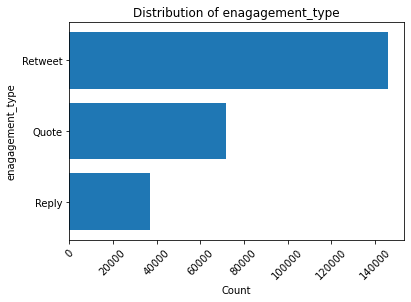

In [10]:
enagagement_type = [c[0] for c in count_tweet_enagagement_type]
counts = [c[1] for c in count_tweet_enagagement_type]

plt.barh(enagagement_type[::-1], counts[::-1])
 
plt.ylabel("enagagement_type")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of enagagement_type")
plt.show()

In [11]:
# constants
COUNTRY = 'Singapore'
TOP_RTS_POS_NEG = 5

# 2. Foreign influence: Inferring the influential countries <a id="cell2"></a>

**Influential countries**: Tweets by non-Singapore based users with a high number of engagements - retweets and quoted tweets, by Singapore users. 

##### Selecting tweets created by non-Singapore based users and known geocoding. 

In [12]:
quoted_sg_tweets = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Quote') & 
                             (sg_tweets['quoted_user_geo_coding'] != 'Unknown') & 
                            (sg_tweets['quoted_user_geo_coding'] != 'Singapore')]

rts_sg_tweets = sg_tweets[(sg_tweets['tweet_enagagement_type'] == 'Retweet') & 
                          (sg_tweets['retweeted_user_geo_coding'] != 'Unknown') & 
                          (sg_tweets['retweeted_user_geo_coding'] != 'Singapore')]


##### Merging quoted tweets and retweets

In [13]:
quoted_rts_geo = list(quoted_sg_tweets['quoted_user_geo_coding']) + \
                list(rts_sg_tweets['retweeted_user_geo_coding'])
c_quoted_rts_geo = col.Counter(quoted_rts_geo).most_common()
c_quoted_rts_geo[:25]

[('United States', 26699),
 ('Myanmar', 13061),
 ('Malaysia', 9716),
 ('United Kingdom', 6745),
 ('India', 6367),
 ('Australia', 3257),
 ('Philippines', 3169),
 ('China', 3065),
 ('Thailand', 2449),
 ('Indonesia', 2404),
 ('Japan', 2154),
 ('Canada', 1815),
 ('France', 1754),
 ('Switzerland', 808),
 ('Viet Nam', 713),
 ('Germany', 683),
 ('New Zealand', 622),
 ('South Africa', 556),
 ('Korea, Republic of', 387),
 ('Pakistan', 364),
 ('Spain', 356),
 ('Taiwan, Province of China', 316),
 ('Israel', 291),
 ('Ireland', 285),
 ('Netherlands', 276)]

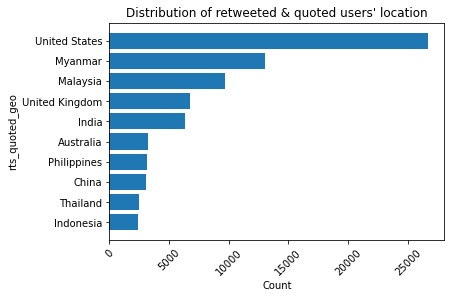

In [14]:
x_top = 10

quoted_rts_geo = [c[0] for c in c_quoted_rts_geo[:x_top]]
quoted_rts_geo_count = [c[1] for c in c_quoted_rts_geo[:x_top]]

plt.barh(quoted_rts_geo[::-1], quoted_rts_geo_count[::-1])
 
plt.ylabel("rts_quoted_geo")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of retweeted & quoted users' location")
plt.show()

##### Loading data containing counties' geolocation and code

In [15]:
countries_data = pd.read_csv("../data/countries_geolocation.csv")
countries_data

,Country,Alpha-2 code,Alpha-3 code,Numeric code,Latitude (average),Longitude (average)
0,Afghanistan,"""AF""","""AFG""","""4""","""33""","""65"""
1,Albania,"""AL""","""ALB""","""8""","""41""","""20"""
2,Algeria,"""DZ""","""DZA""","""12""","""28""","""3"""
3,American Samoa,"""AS""","""ASM""","""16""","""-14.3333""","""-170"""
4,Andorra,"""AD""","""AND""","""20""","""42.5""","""1.6"""
...,...,...,...,...,...,...
251,Wallis and Futuna,"""WF""","""WLF""","""876""","""-13.3""","""-176.2"""
252,Western Sahara,"""EH""","""ESH""","""732""","""24.5""","""-13"""
253,Yemen,"""YE""","""YEM""","""887""","""15""","""48"""
254,Zambia,"""ZM""","""ZMB""","""894""","""-15""","""30"""


In [16]:
SINGAPORE_LONG_LAT = countries_data[countries_data['Country'] == 'Singapore']

sg_long = float(SINGAPORE_LONG_LAT.iloc[0]['Longitude (average)'].strip().strip('"'))  #.iloc(0)['Longitude (average)']
sg_lat = float(SINGAPORE_LONG_LAT.iloc[0]['Latitude (average)'].strip().strip('"'))

sg_long, sg_lat

(103.8, 1.3667)

In [17]:
top_country_influencer = c_quoted_rts_geo[:10]
top_country_influencer

[('United States', 26699),
 ('Myanmar', 13061),
 ('Malaysia', 9716),
 ('United Kingdom', 6745),
 ('India', 6367),
 ('Australia', 3257),
 ('Philippines', 3169),
 ('China', 3065),
 ('Thailand', 2449),
 ('Indonesia', 2404)]

In [18]:
quoted_rts_geo_count

[26699, 13061, 9716, 6745, 6367, 3257, 3169, 3065, 2449, 2404]

In [19]:
# preparing data for the dashboard
top_influential_countries_data = {
    'country': [],
    'lat': [],
    'long': [],
    'count': [],
    'size': []
}

sum_influence = sum([c[1] for c in top_country_influencer])

for i in top_country_influencer:
    top_influential_countries_data['country'].append(i[0])
    top_influential_countries_data['count'].append(i[1])
    top_influential_countries_data['size'].append(round(i[1]/sum_influence*150, 2))
    country_loc = countries_data[countries_data['Country'] == i[0]]
    top_influential_countries_data['long'].append(float(country_loc.iloc[0]['Longitude (average)'].strip().strip('"')))
    top_influential_countries_data['lat'].append(float(country_loc.iloc[0]['Latitude (average)'].strip().strip('"')))
    

In [20]:
top_influential_countries_df = pd.DataFrame(top_influential_countries_data)
pd.DataFrame.to_csv(top_influential_countries_df, '../data/output/influencers/top_countries.csv')
top_influential_countries_df

,country,lat,long,count,size
0,United States,38.0,-97.0,26699,52.06
1,Myanmar,22.0,98.0,13061,25.47
2,Malaysia,2.5,112.5,9716,18.94
3,United Kingdom,54.0,-2.0,6745,13.15
4,India,20.0,77.0,6367,12.41
5,Australia,-27.0,133.0,3257,6.35
6,Philippines,13.0,122.0,3169,6.18
7,China,35.0,105.0,3065,5.98
8,Thailand,15.0,100.0,2449,4.77
9,Indonesia,-5.0,120.0,2404,4.69


##### Saving tweets from the top influential countries for word frequencies analysis 

In [21]:
top_influential_countries = top_influential_countries_df['country']
top_countries_tweets = sg_tweets[(sg_tweets['retweeted_user_geo_coding'].isin(top_influential_countries))
                                & (sg_tweets['processed_tweet_text'].notna())] \
                        [['retweeted_user_geo_coding', 'processed_tweet_text']]
pd.DataFrame.to_csv(top_countries_tweets, '../data/output/influencers/top_countries_data.csv')

In [22]:
top_countries_tweets

,retweeted_user_geo_coding,processed_tweet_text
11,United States,evidence coronavirus came natureit genetically modified came
12,United States,took daughter kindergarten orientation vaccine passport admission let sink
13,Indonesia,progam unggulan ternak ikan yonif 126 / tingkatkan ketahanan pangan warga papua tengah pandemi covid
19,United States,months colleagues calling investigation ccps role origins
21,United States,covid policies matter test positivity rates alabama % florida % texas % california % massach
...,...,...
345180,United States,remember expression door closes door opens healthy ppl forced sell
345182,Malaysia,daily vaccination report states september 2021
345184,Malaysia,cumulative vaccination report state september 2021
345195,United Kingdom,watch military walk outs occurred biden mandates vaccines federal employees military fighter jet pilots


# 3. Bursty tweets: Inferring tweets with high intensity of extreme sentiments <a id="cell3"></a>

**Viral quoted tweets**:
Tweets created between MIN_DATE and MAX_DATE that are (1) highly quoted by count or (2) received an unusual number of endorsements - retweets and favorites

**Bursty tweets**: Viral quoted tweets with high intensity ( >= 80% ) of extreme sentiments (positive and negative sentiments)

### 3.1. Inferring viral quoted tweets <a id="cell31"></a>

##### Filtering quoted tweets 

##### Cleaning and formatting tweets

In [23]:
tweet_enagagement_quotes = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Quote']
tweet_enagagement_quotes.shape

(71847, 54)

##### Formating `quoted_tweet_time` and adding `quoted_tweet_date`

In [24]:
tweet_enagagement_quotes['quoted_tweet_time'] = pd.to_datetime(tweet_enagagement_quotes['quoted_tweet_time'], errors='coerce')
tweet_enagagement_quotes = tweet_enagagement_quotes.dropna(subset=['quoted_tweet_time'])
tweet_enagagement_quotes['quoted_tweet_date'] = tweet_enagagement_quotes.quoted_tweet_time.dt.strftime('%Y-%m-%d')

##### Adding `total_engagement` = `quoted_retweet_count` + `quoted_favorite_count`

##### Quoted tweets created between MIN_DATE and MAX_DATE

In [25]:
tweet_enagagement_quotes['total_engagement'] = tweet_enagagement_quotes['quoted_retweet_count']  + tweet_enagagement_quotes['quoted_favorite_count'] 

tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']] = tweet_enagagement_quotes[['quoted_tweet_id', 'total_engagement']].astype(int)
tweet_enagagement_quotes = tweet_enagagement_quotes.loc[:, ~tweet_enagagement_quotes.columns.str.contains('^Unnamed')]

##### (1) Filtering quoted tweets created between `MIN_DATE` and `MAX_DATE`

In [26]:
quoted_tweets = tweet_enagagement_quotes[(tweet_enagagement_quotes['quoted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

##### (2) Filtering highly quoted by count 

##### Top quoted tweets by spike in engagements

In [27]:
# count of RTs
c_quoted = quoted_tweets.value_counts(subset=['quoted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)
# top RTs by count
quoted_qids_by_count = list(c_quoted[:10]['quoted_tweet_id'])

##### (3) Filtering anomalous quoted tweets - with an unusual number of engagements.

In [203]:
SPIKE_THRESHOLD = 300 # TODO: Find a threshold using stats (like from outliers)
grouped_sorted_date = quoted_tweets.groupby(['quoted_tweet_id', 'quoted_tweet_date']).apply(pd.DataFrame.sort_values, 'quoted_tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['quoted_tweet_id', 'quoted_tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['quoted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('quoted_tweet_id').nth(0)
spike = list(spike[spike['delta_engagement'] > SPIKE_THRESHOLD].reset_index()['quoted_tweet_id'])

##### Get viral RTs by count and spiky engagements

In [204]:
viral_quoted_tweets = quoted_tweets[quoted_tweets['quoted_tweet_id'].isin(quoted_qids_by_count + spike)]

##### get data for delta and cumulative graphs


In [167]:
grouped_sorted_date = viral_quoted_tweets.groupby(['quoted_tweet_id', 'tweet_date', 'quoted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['quoted_tweet_id', 'tweet_date', 'quoted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['quoted_user_screenname'])['total_engagement'].diff().fillna(0).astype(int)

### 3.2. Sentiment analysis of the viral quoted tweets <a id="cell32"></a>

In [168]:
quoted_by_sentiment = viral_quoted_tweets.groupby(['quoted_tweet_id', 'tweet_sentiment']).size()\
                        .unstack(fill_value=0).reset_index()
quoted_by_sentiment

tweet_sentiment,quoted_tweet_id,negative,neutral,positive
0,1424662560909922304,3,7,96
1,1426481587437260800,102,17,91
2,1426774237096812288,1,94,0
3,1427581320822104064,0,101,0
4,1428304817970040832,1,23,72
5,1428675725645819904,43,36,25
6,1431940550656081920,21,81,86
7,1437736253563162624,5,92,8
8,1438395703185735680,252,26,8
9,1439236328772669440,85,7,0


In [170]:
quoted_by_sentiment['pos_count'] = quoted_by_sentiment['positive'] / (quoted_by_sentiment['positive'] + 
                                                                      quoted_by_sentiment['negative'] + 
                                                                      quoted_by_sentiment['neutral'])*100 


quoted_by_sentiment['neg_count'] = quoted_by_sentiment['negative'] / (quoted_by_sentiment['positive'] + 
                                                                      quoted_by_sentiment['negative'] + 
                                                                      quoted_by_sentiment['neutral'])*100 

### 3.3. Inferring viral quoted tweets with extreme intensity of sentiments (>= 80% of postive or negative sentiment) <a id="cell33"></a>

In [171]:
most_spread_quoted_by_sentiment_with_rate = quoted_by_sentiment[(quoted_by_sentiment['pos_count'] >= 80) | (quoted_by_sentiment['neg_count'] >= 80)]
most_spread_quoted_by_sentiment_with_rate

tweet_sentiment,quoted_tweet_id,negative,neutral,positive,pos_count,neg_count
0,1424662560909922304,3,7,96,90.566038,2.830189
8,1438395703185735680,252,26,8,2.797203,88.111888
9,1439236328772669440,85,7,0,0.000000,92.391304


In [172]:
most_spread_quoted_ids = list(most_spread_quoted_by_sentiment_with_rate['quoted_tweet_id'])
most_spread_quoted_ids

[1424662560909922304, 1438395703185735680, 1439236328772669440]

In [173]:
most_spread_quoted_info = viral_quoted_tweets[viral_quoted_tweets['quoted_tweet_id'].isin(most_spread_quoted_ids)]

In [174]:
most_spread_quoted_info = most_spread_quoted_info[['quoted_tweet_id', 'quoted_tweet_text', 'quoted_user_screenname', 'quoted_user_geo_coding', 'quoted_tweet_date', 'quoted_user_verified', 'total_engagement']]

In [175]:
most_spread_quoted_info = most_spread_quoted_info.loc[most_spread_quoted_info.groupby(["quoted_tweet_id"])["total_engagement"].idxmax()]  
most_spread_quoted_info

,quoted_tweet_id,quoted_tweet_text,quoted_user_screenname,quoted_user_geo_coding,quoted_tweet_date,quoted_user_verified,total_engagement
50103,1424662560909922304,"Pro tip for all our F&B friends:\nFrom tomorrow, some anti-vax mooks might try to pull a fast one by screenshotting… https://t.co/jpiukrblZl",muttons,Unknown,2021-08-09,True,2188
89270,1438395703185735680,Endemic Covid-19: Expect to get infected sooner or later: https://t.co/xnmNTPRbyz https://t.co/CiEfVTeEJu,MothershipSG,Singapore,2021-09-16,True,964
171855,1439236328772669440,"According to local media The Chinland Post, over 19 houses were burnt down by junta forces’ shelling in Thantlang,… https://t.co/TXpdBe9MAa",Shoon_Naing,Myanmar,2021-09-18,True,3882


In [176]:
final_most_spread_quoted = most_spread_quoted_info.merge(most_spread_quoted_by_sentiment_with_rate, on="quoted_tweet_id", how = 'inner')
final_most_spread_quoted.shape

(3, 12)

In [177]:
final_most_spread_quoted.drop(['negative', 'positive', 'neutral'], 1, inplace=True) 

##### Adding `spread_type` and `spread_rate`. 80% <= positivity spread and 80% <= negativity spread

In [178]:
final_most_spread_quoted['spread_type'] = ['positive' if spread_rate >= 80 else 'negative' for spread_rate in final_most_spread_quoted['pos_count']]
final_most_spread_quoted['spread_rate'] = [round(row['pos_count'], 2) if row['spread_type'] == 'positive' 
                                           else round(row['neg_count'], 2) for _, row in final_most_spread_quoted.iterrows()]

In [179]:
final_most_spread_quoted.drop(['pos_count', 'neg_count'], 1, inplace=True) 
pd.DataFrame.to_csv(final_most_spread_quoted, '../data/output/quoted/sentiment_spread.csv')

## 4. Viral local retweets: Local news feed <a id="cell4"></a>

##### Viral local retweets:Tweets created between MIN_DATE and MAX_DATE that are (1) by Singapore geocoded accounts (2) highly retweeted by count or (3) received an unusual number of endorsements - retweets and favorites


In [23]:
tweet_enagagement_retweet = sg_tweets[sg_tweets['tweet_enagagement_type'] == 'Retweet']

In [24]:
## retweet time processing
tweet_enagagement_retweet['retweeted_tweet_time'] = pd.to_datetime(tweet_enagagement_retweet['retweeted_tweet_time'], errors='coerce')
tweet_enagagement_retweet = tweet_enagagement_retweet.dropna(subset=['retweeted_tweet_time'])
tweet_enagagement_retweet['retweeted_tweet_date'] = tweet_enagagement_retweet.retweeted_tweet_time.dt.strftime('%Y-%m-%d')

In [25]:
rts_geo = tweet_enagagement_retweet['retweeted_user_geo_coding']

c_rts_geo = col.Counter(rts_geo).most_common()
# c_rts_geo

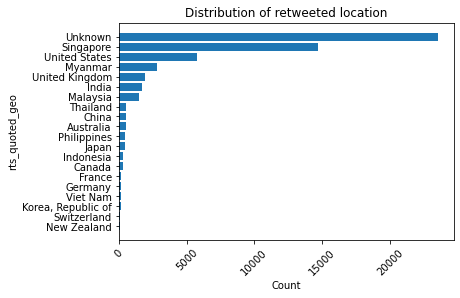

In [26]:
x_top = 20

rts_geo = [c[0] for c in c_rts_geo[:x_top]]
counts = [c[1] for c in c_rts_geo[:x_top]]

plt.barh(rts_geo[::-1], counts[::-1])
 
plt.ylabel("rts_quoted_geo")
plt.xlabel("Count")
plt.xticks(rotation=45)
plt.title("Distribution of retweeted location")
plt.show()


In [27]:
tweet_enagagement_retweet['total_engagement'] = tweet_enagagement_retweet['retweeted_retweet_count']  + tweet_enagagement_retweet['retweeted_favorite_count'] 
tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']] = tweet_enagagement_retweet[['retweeted_tweet_id', 'total_engagement']].astype(int)

tweet_enagagement_retweet = tweet_enagagement_retweet.loc[:, ~tweet_enagagement_retweet.columns.str.contains('^Unnamed')]

##### Filtering tweets (1) by sentiment, (2) by Singapore-based user and (3) created between MIN_DATE and MAX_DATE

In [28]:
neg_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

pos_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

all_local_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] ==  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

### 4.1. Viral local retweets with negative sentiment <a id="cell41"></a>

In [186]:
neg_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count')

,retweeted_tweet_id,local_count
0,1440562070898962432,100
1,1424598213856620288,68
2,1438395703185735680,35
3,1425698659115491328,31
4,1434725178240499712,31
...,...,...
1780,1428891365992144896,1
1781,1428844814909333504,1
1782,1428841803126435840,1
1783,1428840278648004608,1


In [30]:
# count of RTs
SPIKE_THRESHOLD = 600 # TODO: Find a threshold using stats (like from outliers)
c_neg_local_retweet = neg_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)

# top RTs by count
neg_local_rtids_by_count = list(c_neg_local_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = neg_local_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike[spike['delta_engagement'] > SPIKE_THRESHOLD].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_neg_local_rts = neg_local_retweet[neg_local_retweet['retweeted_tweet_id'].isin(set(neg_local_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_neg_local_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, '../data/output/rts/local/neg_local_rts_trend.csv')

In [34]:
c_neg_local_retweet['local_count'].describe()

count    1785.000000
mean        1.661064
std         3.562852
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max       100.000000
Name: local_count, dtype: float64

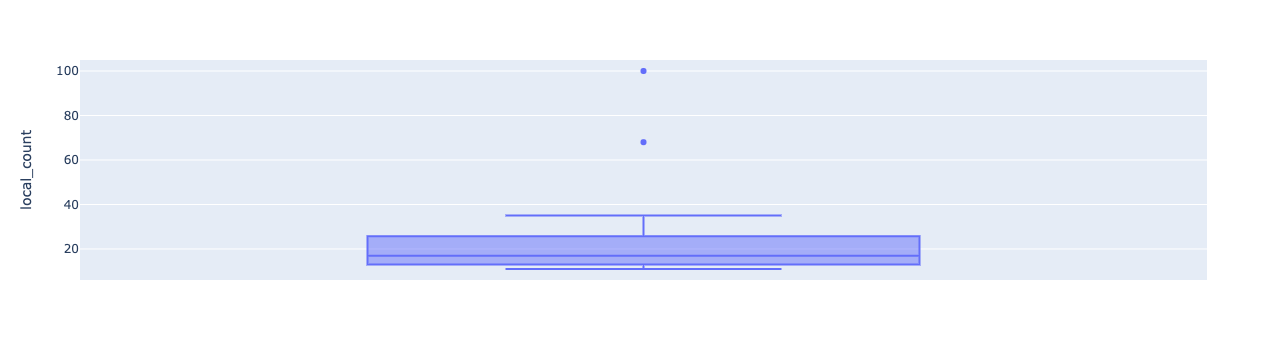

In [44]:
c_neg_local_retweet[['local_count']] = c_neg_local_retweet[['local_count']].astype(int)
sub_neg_local_retweet = c_neg_local_retweet[c_neg_local_retweet['local_count'] > 10]
fig = px.box(sub_neg_local_retweet, y="local_count")
fig.show()

In [209]:
viral_neg_local_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_neg_local_rts['tweet_text'] ]

details_viral_neg_local_rts = viral_neg_local_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_neg_local_rts = details_viral_neg_local_rts.loc[:, ~details_viral_neg_local_rts.columns.str.contains('^Unnamed')]

details_viral_neg_local_rts

k = px.colors.qualitative.Pastel[:details_viral_neg_local_rts.shape[0]]
details_viral_neg_local_rts['color'] = k

pd.DataFrame.to_csv(details_viral_neg_local_rts, '../data/output/rts/local/neg_local_rts_info.csv')

### 4.2. Viral local retweets with positive sentiment <a id="cell42"></a>

In [119]:
# count of RTs
SPIKE_THRESHOLD = 1500 # TODO: Find a threshold using stats (like from outliers)
c_pos_local_retweet = pos_local_retweet.value_counts(subset=['retweeted_tweet_id']).reset_index(name='local_count').sort_values('local_count', ascending=False)

# top RTs by count
pos_local_rtids_by_count = list(c_pos_local_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = pos_local_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike_ = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike_[spike_['delta_engagement'] >= SPIKE_THRESHOLD].reset_index()['retweeted_tweet_id'])

# print("By count: ", len(pos_local_rtids_by_count))
# print("By spike: ", len(spike))
# get viral RTs by count and spiky engagements
viral_pos_local_rts = pos_local_retweet[pos_local_retweet['retweeted_tweet_id'].isin(set(pos_local_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_pos_local_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, '../data/output/rts/local/pos_local_rts_trend.csv')



In [120]:
spike_['delta_engagement'].describe()

count     243.000000
mean      121.094650
std       357.087315
min         0.000000
25%         8.000000
50%        30.000000
75%        87.500000
max      4443.000000
Name: delta_engagement, dtype: float64

quantile 956.4399999999999
sub_spike.shape (5, 3)
       total_engagement  delta_engagement
count          5.000000          5.000000
mean        5702.800000       1930.400000
std         4941.306022       1486.876525
min         1354.000000        964.000000
25%         2486.000000       1005.000000
50%         4504.000000       1097.000000
75%         6306.000000       2143.000000
max        13864.000000       4443.000000


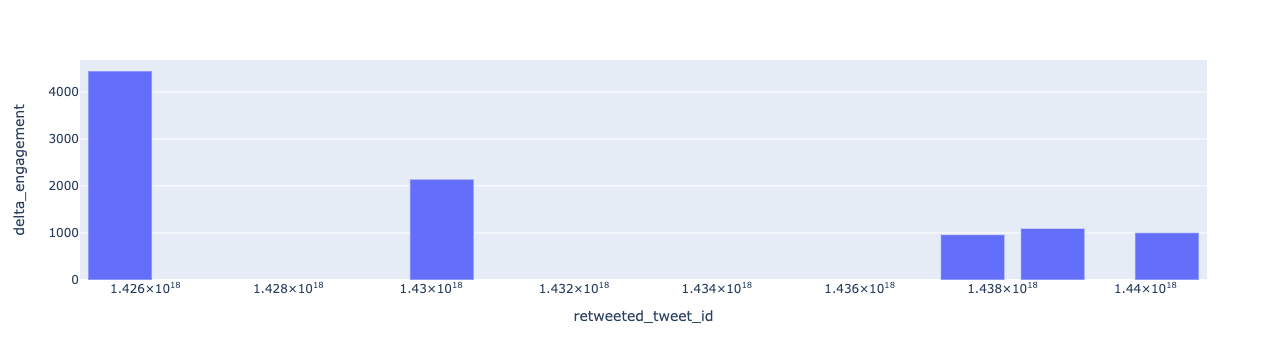

In [121]:
t = spike_['delta_engagement']
sub_spike_2 = t.quantile(.98)
print("quantile", sub_spike_2)
sub_spike = spike_[spike_['delta_engagement'] > sub_spike_2]
print("sub_spike.shape", sub_spike.shape)
print(sub_spike.describe())
fig = px.bar(sub_spike, y="delta_engagement")
fig.show()

In [49]:
# c_pos_local_retweet[['local_count']] = c_pos_local_retweet[['local_count']].astype(int)
# sub_c_pos_local_retweet = c_pos_local_retweet[c_pos_local_retweet['local_count'] > 10]
# fig = px.box(sub_c_pos_local_retweet, y="local_count")
# fig.show()

In [211]:
viral_pos_local_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_pos_local_rts['tweet_text'] ]

details_viral_pos_local_rts = viral_pos_local_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment', 'retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_pos_local_rts = details_viral_pos_local_rts.loc[:, ~details_viral_pos_local_rts.columns.str.contains('^Unnamed')]

details_viral_pos_local_rts


# details_viral_pos_local_rts.index.name = 'index'

k = px.colors.qualitative.Pastel[:details_viral_pos_local_rts.shape[0]]
details_viral_pos_local_rts['color'] = k


pd.DataFrame.to_csv(details_viral_pos_local_rts, '../data/output/rts/local/pos_local_rts_info.csv')

## 5. Viral global retweets: Global news feed <a id="cell5"></a>

Viral global retweets:Tweets created between MIN_DATE and MAX_DATE that are (1) by Non-Singapore geocoded accounts (2) highly retweeted by count or (3) received an unusual number of endorsements - retweets and favorites

In [110]:
neg_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'negative') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

pos_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['tweet_sentiment'] == 'positive') & \
                                                    (tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                                    (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

all_global_retweet = tweet_enagagement_retweet[(tweet_enagagement_retweet['retweeted_user_geo_coding'] !=  COUNTRY) & \
                                               (tweet_enagagement_retweet['retweeted_tweet_date'].between(MIN_DATE, MAX_DATE, inclusive=True))]

### 5.1. Viral global retweets with negative sentiment <a id="cell51"></a>

In [115]:
# count of RTs
SPIKE_THRESHOLD = 240000 # TODO: Find a threshold using stats (like from outliers)

c_neg_global_retweet = neg_global_retweet.value_counts(subset=['retweeted_tweet_id']) \
                        .reset_index(name='global_count').sort_values('global_count', ascending=False)

# top RTs by count
neg_global_rtids_by_count = list(c_neg_global_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = neg_global_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike_ = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike_[spike_['delta_engagement'] > SPIKE_THRESHOLD].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_neg_global_rts = neg_global_retweet[neg_global_retweet['retweeted_tweet_id'].isin(set(neg_global_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_neg_global_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, '../data/output/rts/global/neg_global_rts_trend.csv')

quantile 87422.51999999996
sub_spike.shape (10, 3)
       total_engagement  delta_engagement
count         10.000000         10.000000
mean      260923.700000     135514.700000
std       122922.190009      42114.479326
min        96988.000000      90881.000000
25%       179418.250000     102511.750000
50%       254212.000000     121175.000000
75%       301147.750000     169337.500000
max       478264.000000     211428.000000


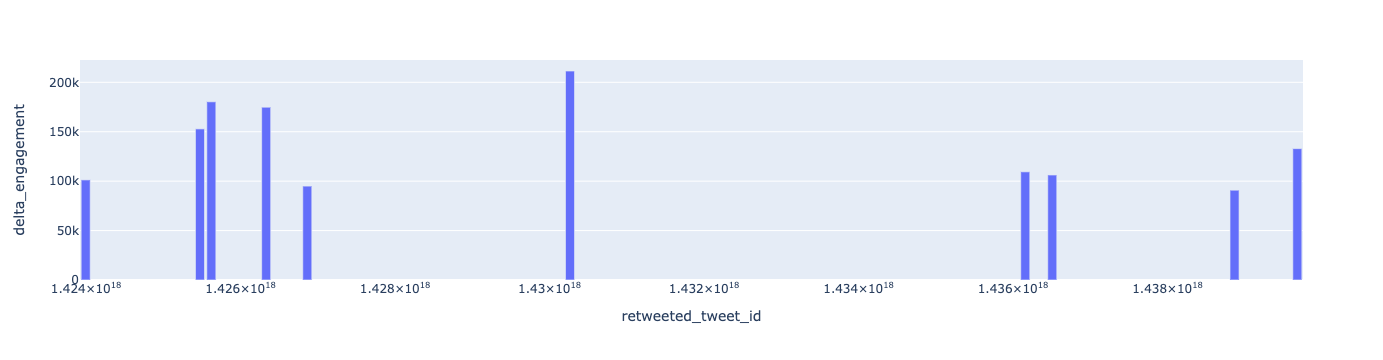

In [116]:
t = spike_['delta_engagement']
sub_spike_2 = t.quantile(.98)
print("quantile", sub_spike_2)
sub_spike = spike_[spike_['delta_engagement'] > sub_spike_2]
print("sub_spike.shape", sub_spike.shape)
print(sub_spike.describe())
fig = px.bar(sub_spike, y="delta_engagement")
fig.show()

In [214]:
viral_neg_global_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_neg_global_rts['tweet_text'] ]

details_viral_neg_global_rts = viral_neg_global_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_neg_global_rts = details_viral_neg_global_rts.loc[:, ~details_viral_neg_global_rts.columns.str.contains('^Unnamed')]
k = px.colors.qualitative.Pastel[:details_viral_neg_global_rts.shape[0]]

details_viral_neg_global_rts['color'] = k

pd.DataFrame.to_csv(details_viral_neg_global_rts, '../data/output/rts/global/neg_global_rts_info.csv')

### 5.2. Viral global retweets with positive sentiment <a id="cell52"></a>

In [117]:
# count of RTs
SPIKE_THRESHOLD = 280000 # TODO: Find a threshold using stats (like from outliers)

c_pos_global_retweet = pos_global_retweet.value_counts(subset=['retweeted_tweet_id']) \
                        .reset_index(name='global_count').sort_values('global_count', ascending=False)

# top RTs by count
pos_global_rtids_by_count = list(c_pos_global_retweet[:TOP_RTS_POS_NEG]['retweeted_tweet_id'])

# top RTs by spike in engagements
grouped_sorted_date = pos_global_retweet.groupby(['retweeted_tweet_id', 'tweet_date']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)
spike_ = max_grouped_sorted_date.groupby('retweeted_tweet_id').nth(1)
spike = list(spike_[spike_['delta_engagement'] > SPIKE_THRESHOLD].reset_index()['retweeted_tweet_id'])

# get viral RTs by count and spiky engagements
viral_pos_global_rts = pos_global_retweet[pos_global_retweet['retweeted_tweet_id'].isin(set(pos_global_rtids_by_count + spike))]

# get data for delta and cumulative graphs
grouped_sorted_date = viral_pos_global_rts.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname']).apply(pd.DataFrame.sort_values, 'tweet_date').reset_index(drop=True)
max_grouped_sorted_date = grouped_sorted_date.groupby(['retweeted_tweet_id', 'tweet_date', 'retweeted_user_screenname'])['total_engagement'].max().reset_index()
max_grouped_sorted_date['delta_engagement'] = max_grouped_sorted_date.groupby(['retweeted_tweet_id'])['total_engagement'].diff().fillna(0).astype(int)

pd.DataFrame.to_csv(max_grouped_sorted_date, '../data/output/rts/global/pos_global_rts_trend.csv')

quantile 106560.27999999996
sub_spike.shape (13, 3)
       total_engagement  delta_engagement
count         13.000000         13.000000
mean      275269.538462     165792.076923
std       115784.795665      60295.265133
min       113891.000000     110466.000000
25%       175035.000000     121274.000000
50%       279969.000000     129446.000000
75%       339695.000000     217940.000000
max       445093.000000     281020.000000


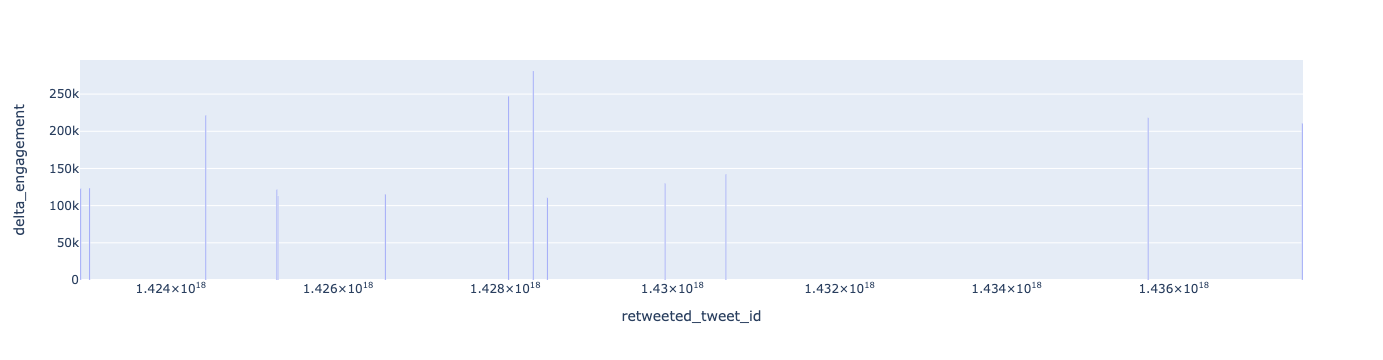

In [118]:
t = spike_['delta_engagement']
sub_spike_2 = t.quantile(.98)
print("quantile", sub_spike_2)
sub_spike = spike_[spike_['delta_engagement'] > sub_spike_2]
print("sub_spike.shape", sub_spike.shape)
print(sub_spike.describe())
fig = px.bar(sub_spike, y="delta_engagement")
fig.show()

In [216]:
viral_pos_global_rts['tweet_text_'] = [re.sub("RT @[A-Z_a-z_0-9:]+","", txt).strip() for txt in viral_pos_global_rts['tweet_text'] ]

details_viral_pos_global_rts = viral_pos_global_rts[['tweet_text_', 'tweet_date', 'tweet_sentiment','retweeted_user_screenname', 'total_engagement',
                                                   'retweeted_user_verified', 'retweeted_tweet_id']] \
                                                .groupby('retweeted_tweet_id') \
                                                .apply(pd.DataFrame.sort_values, 'total_engagement') \
                                                .reset_index(drop=True).groupby('retweeted_tweet_id').last().reset_index()


details_viral_pos_global_rts = details_viral_pos_global_rts.loc[:, ~details_viral_pos_global_rts.columns.str.contains('^Unnamed')]
k = px.colors.qualitative.Pastel[:details_viral_pos_global_rts.shape[0]]

details_viral_pos_global_rts['color'] = k

pd.DataFrame.to_csv(details_viral_pos_global_rts, '../data/output/rts/global/pos_global_rts_info.csv')